# Notebook to generate the plots for the Replicator Dynamics and Cross Learning

In [1]:
# turn off to plot only the replicator dynamics, not the CrossLearning trajectories
plot_CrossLearning = True
plot_time_evolution = True
plot_colorbar = True
plot_speed_colorbar = False
plot_imshow = True
num_ticks = 2

figsize = (4,4)
dpi=200
file='jpg'
fontsize = None

# parameters for streamplot
arrowsize = 1
density = 0.5
linewidth = 0.5

# parameters for the colormap of the imshow
color_map = 'binary_r' # color map for the plots, e.g., 'viridis', 'plasma', 'inferno', 'magma', 'cividis', 'binary', 'twighlight', 'twighlight_shifted', 'hsv', 'Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c'
color_map_streamplots = None
alpha = 0.5 # transparency of the colormap

# parameters for the trajectory plot
linewidth_traj = 2

In [2]:
# import general libraries
import numpy as np
from scipy.signal import periodogram
from scipy.signal import welch
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from matplotlib.collections import LineCollection
# import from the file multiplayer_prisoners_dilemma.py
from multiplayer_prisoners_dilemma import CrossLearningAgent
from multiplayer_prisoners_dilemma import Game
from multiplayer_prisoners_dilemma import Simulation

# define the reward function for the two player prisoner's dilemma
def reward_matrix_for_two_player_PD(action_vector, player_id):
    action_tuple = tuple(action_vector)
    S, P, R, T = 0, 1, 3, 5
    reward_matrix = {
            (0, 0): (P, P),  # Both defect
            (0, 1): (T, S),  # Agent A defects, agent B cooperates
            (1, 0): (S, T),  # Agent A cooperates, agent B defects
            (1, 1): (R, R),  # Both cooperate
        }
    reward = reward_matrix[action_tuple]
    return reward[player_id]

# define the reward function for the two player prisoner's dilemma
def reward_matrix_for_two_player_matching_pennies(action_vector, player_id):
    action_tuple = tuple(action_vector)
    H, T = 1, -0
    reward_matrix = {
            (0, 0): (H, T),  # 
            (0, 1): (T, H),  
            (1, 0): (T, H),  
            (1, 1): (H, T),  
        }
    reward = reward_matrix[action_tuple]
    return reward[player_id]

# define the reward function for the two player stag hunt
def reward_matrix_for_two_player_stag_hunt(action_vector, player_id):
    action_tuple = tuple(action_vector)
    reward_matrix = {
            (0, 0): (4, 4),  # 
            (0, 1): (1, 3),  # 
            (1, 0): (3, 1),  # 
            (1, 1): (3, 3),  # 
        }
    reward = reward_matrix[action_tuple]
    return reward[player_id]

# define the reward function for the two player battle of sexes
def reward_matrix_for_two_player_battle_of_sexes(action_vector, player_id):
    action_tuple = tuple(action_vector)
    reward_matrix = {
            (0, 0): (3, 2),  # 
            (0, 1): (0, 0),  # 
            (1, 0): (0, 0),  # 
            (1, 1): (2, 3),  # 
        }
    reward = reward_matrix[action_tuple]
    return reward[player_id]

# Define the replicator dynamics function
def f(x):
    p1, p2 = x
    prob_vector1 = [p1, 1-p1]
    prob_vector2 = [p2, 1-p2]
    payoff1 = np.dot(A, prob_vector2)
    payoff2 = np.dot(prob_vector1, B)
    avg_payoff1 = np.dot(prob_vector1, payoff1)
    avg_payoff2 = np.dot(prob_vector2, payoff2)
    p1_dot = p1 * (payoff1[0] - avg_payoff1)
    p2_dot = p2 * (payoff2[0] - avg_payoff2)
    return np.array([p1_dot, p2_dot])

# Generate a grid of points in the unit square
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)

# game and learning parameters
num_players = 2
action_space = np.array([0 ,  1], dtype=float) # (0 = first action, 1 = second action)
learning_rate = 0.001
initial_policy = np.array([[0.3, 0.7]])

# define the initial probabilities for the agents for Cross Learning
# for the Prisoner's Dilemma game and the Bach-Stravisky game
initial_probabilities_PD_BS = [(0.2, 0.8), (0.5, 0.8), (0.8, 0.8),
                        (0.2, 0.5), (0.5, 0.5), (0.8, 0.5),
                        (0.2, 0.2), (0.5, 0.2), (0.8, 0.2)]

# for the Matching Pennies game
initial_probabilities_MP = [(0.1, 0.5), (0.3, 0.5), (0.5, 0.5)]

colors= plt.cm.plasma(np.linspace(0, 1, len(initial_probabilities_PD_BS))) # Creating a color map from blue to red for the different initial probabilities

# Prisoner's Dilemma

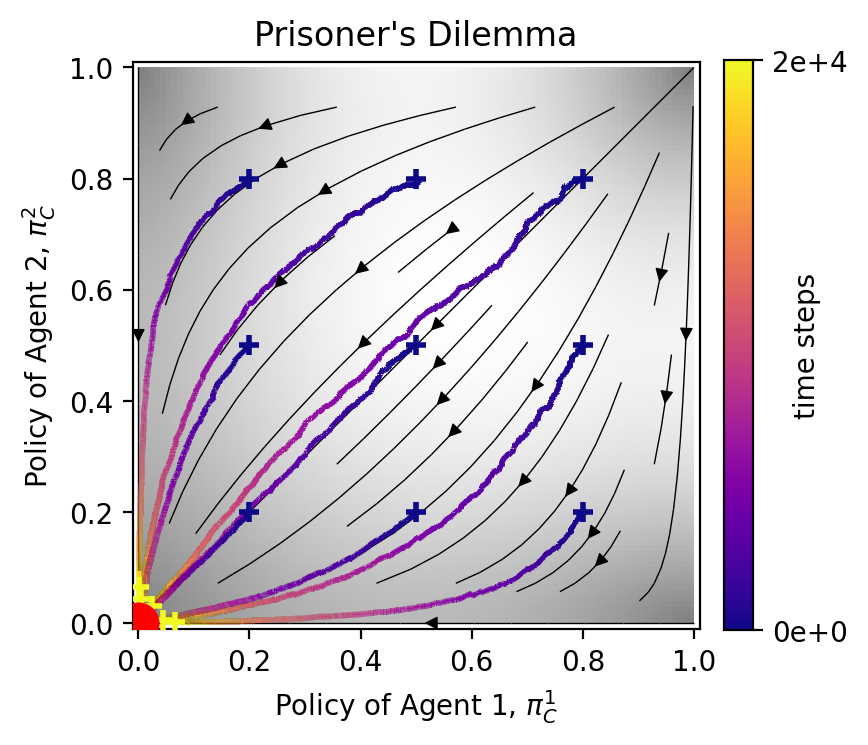

In [3]:
# Define the payoff matrix
A = np.array([[3, 0], [5, 1]]) # payoff matrix for the first player: 0 = cooperate, 1 = defect
B = np.array([[3, 5], [0, 1]]) # payoff matrix for the second player: 0 = cooperate, 1 = defect

# Calculate the time derivatives at each point
U, V = np.zeros(X.shape), np.zeros(Y.shape)
speed = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        x = X[i, j]
        y = Y[i, j]
        dx = f([x, y])
        U[i, j] = dx[0]
        V[i, j] = dx[1]
        speed[i, j] = np.sqrt(dx[0]**2 + dx[1]**2)

num_time_steps = int(2e4)
trajectory_array = []
for initial_probability_tupel in initial_probabilities_PD_BS:
    initial_policy_agent1 = np.array([[1 - initial_probability_tupel[0], initial_probability_tupel[0]]])
    initial_policy_agent2 = np.array([[1 - initial_probability_tupel[1], initial_probability_tupel[1]]])
    initial_policy_array = np.array([initial_policy_agent1, initial_policy_agent2])
    # create the agents
    agents = [CrossLearningAgent(player_id = i, 
                    action_space = action_space,
                    num_players = num_players,
                    reward_func = reward_matrix_for_two_player_PD,
                    learning_rate = learning_rate,
                    policy = initial_policy_array[i],
                    )       
                    for i in range(num_players)]
    agent1, agent2 = agents
    # Create a game and a Simulation
    game = Game(agents = agents)
    simulation = Simulation()
    # run once
    simulation.run(game, agents, num_time_steps)
    # Extract cooperation probabilities from the policy history
    p1 = [policy[0][1] for policy in agent1.policy_history]
    p2 = [policy[0][1] for policy in agent2.policy_history]
    trajectory_array.append((p1, p2))

# Set the figure size
plt.figure(figsize=figsize, dpi=dpi)
# Create the color map
if plot_imshow:
    plt.imshow(speed, extent=(0, 1, 0, 1), origin='lower', cmap=color_map, alpha=alpha)
    if not plot_CrossLearning and plot_speed_colorbar:
        plt.colorbar(label='speed')
# Plot the streamlines
plt.streamplot(X, Y, U, V, arrowsize=arrowsize, density=density, color='black', linewidth=linewidth)#, linewidth=linewidth*speed/speed.max(), color=speed, cmap=color_map)
# Plot the Nash Equilibrium
plt.scatter(0., 0., color='red', s=200, label='Nash Equilibrium', zorder=9, clip_on=True) # set clip_on to False to show the point outside the axes
# Plot the trajectory of Cross Learning
if plot_CrossLearning:
    # Before plotting trajectories, initialize a list to collect all lines
    all_lines = []
    for i, trajectory in enumerate(trajectory_array):
        p1, p2 = trajectory
        if plot_time_evolution:
            # Collect lines for the current trajectory
            lines = [((p1[i], p2[i]), (p1[i+1], p2[i+1])) for i in range(num_time_steps-1)]
            all_lines.extend(lines)  # Add current trajectory lines to all_lines
            start_scatter = plt.scatter(p1[0], p2[0], color=colors[0], label='start', marker='+', s=50, linewidths=2, zorder=8)
            end_scatter = plt.scatter(p1[-1], p2[-1], color=colors[-1], label='end', marker='+', s=50, linewidths=2, zorder=8)
        else:
            plt.plot(p1, p2, color=colors[i], label='Cross Learning', zorder=10)
            # plot the starting point
            start_scatter = plt.scatter(p1[0], p2[0], color=colors[i], label='start', marker='+', s=50, linewidths=2, zorder=8)

    # After collecting lines from all trajectories
    if plot_time_evolution:
        # Create a LineCollection for all trajectories
        lc = LineCollection(all_lines, cmap='plasma', linewidths=linewidth_traj)
        # Set the colors of the lines to correspond to the time steps
        lc.set_array(np.arange(num_time_steps))
        plt.gca().add_collection(lc)
        if plot_colorbar:
            # Add a colorbar for the time evolution
            cbar = plt.colorbar(lc, fraction=0.046, pad=0.04)
            cbar.set_label('time steps', labelpad=-20, y=0.5)
            tick_values = np.linspace(0, num_time_steps-1, num=num_ticks).astype(int)
            cbar.set_ticks(tick_values)  # Set the ticks to the desired positions
            # Format tick labels into scientific notation manually
            tick_labels = [0, num_time_steps]
            tick_labels_scientific_notation = ["{:.0e}".format(tick_label) for tick_label in tick_labels]
            # Define a custom formatter to remove the leading zero in the exponent
            def custom_formatter(x):
                return f'{x:.0e}'.replace('e+0', 'e+').replace('e-0', 'e-')
            tick_labels_scientific_notation_reduced = [custom_formatter(tick_label) for tick_label in tick_labels]
            cbar.set_ticklabels([tick_label for tick_label in tick_labels_scientific_notation_reduced])
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
# Make the aspect ratio of the x and y axes equal
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel(r'Policy of Agent 1, $\pi^1_C$', fontsize=fontsize)
plt.ylabel(r'Policy of Agent 2, $\pi^2_C$', fontsize=fontsize)
plt.title('Prisoner\'s Dilemma')
if plot_CrossLearning:
    plt.savefig(f'Figures/ReplicatorDynamics/ReplicatorDynamics_PD_CL.{file}', dpi=dpi, bbox_inches='tight', facecolor='white')
else:
    plt.savefig(f'Figures/ReplicatorDynamics/ReplicatorDynamics_PD.{file}', dpi=dpi, bbox_inches='tight', facecolor='white')
plt.show()

# Matching Pennies

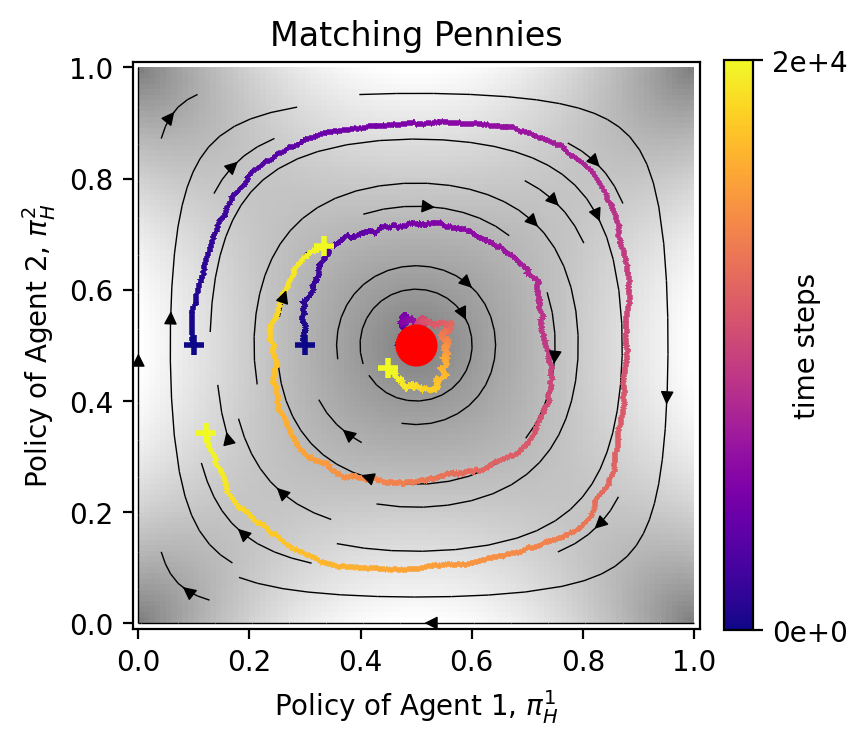

In [4]:
# Define the payoff matrix for Matching Pennies
A = np.array([[1, -0], [-0, 1]])
B = np.array([[-0, 1], [1, -0]])

# Calculate the time derivatives at each point
U, V = np.zeros(X.shape), np.zeros(Y.shape)
speed = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        x = X[i, j]
        y = Y[i, j]
        dx = f([x, y])
        U[i, j] = dx[0]
        V[i, j] = dx[1]
        speed[i, j] = np.sqrt(dx[0]**2 + dx[1]**2)

num_time_steps = int(1.5e4)
trajectory_array = []
for initial_probability_tupel in initial_probabilities_MP:
    initial_policy_agent1 = np.array([[initial_probability_tupel[0], 1 - initial_probability_tupel[0]]])
    initial_policy_agent2 = np.array([[initial_probability_tupel[1], 1 - initial_probability_tupel[1]]])
    initial_policy_array = np.array([initial_policy_agent1, initial_policy_agent2])
    #initial_policy_array = 
    # create the agents
    agents = [CrossLearningAgent(player_id = i, 
                    action_space = action_space,
                    num_players = num_players,
                    reward_func = reward_matrix_for_two_player_matching_pennies,
                    learning_rate = learning_rate,
                    policy = initial_policy_array[i],
                    )       
                    for i in range(num_players)]
    agent1, agent2 = agents
    # Create a game and a Simulation
    game = Game(agents = agents)
    simulation = Simulation()
    # run once
    simulation.run(game, agents, num_time_steps)
    # Extract cooperation probabilities from the policy history
    p1 = [policy[0][0] for policy in agent1.policy_history]
    p2 = [policy[0][0] for policy in agent2.policy_history]
    trajectory_array.append((p1, p2))

# Set the figure size
plt.figure(figsize=figsize, dpi=dpi)
# Create the color map
if plot_imshow:
    plt.imshow(speed, extent=(0, 1, 0, 1), origin='lower', cmap=color_map, alpha=alpha)
    if not plot_CrossLearning and plot_speed_colorbar:
        plt.colorbar(label='speed')
# Plot the streamlines
plt.streamplot(X, Y, U, V, arrowsize=arrowsize, density=density, color='black', linewidth=linewidth)#, linewidth=linewidth*speed/speed.max(), color=speed, cmap=color_map)
# Plot the Nash Equilibrium
plt.scatter(0.5, 0.5, color='red', s=200, label='Nash Equilibrium', zorder=9, clip_on=True) # set clip_on to False to show the point outside the axes
# Plot the trajectory of Cross Learning
if plot_CrossLearning:
    # Before plotting trajectories, initialize a list to collect all lines
    all_lines = []
    for i, trajectory in enumerate(trajectory_array):
        p1, p2 = trajectory
        if plot_time_evolution:
            # Collect lines for the current trajectory
            lines = [((p1[i], p2[i]), (p1[i+1], p2[i+1])) for i in range(num_time_steps-1)]
            all_lines.extend(lines)  # Add current trajectory lines to all_lines
            start_scatter = plt.scatter(p1[0], p2[0], color=colors[0], label='start', marker='+', s=50, linewidths=2, zorder=8)
            end_scatter = plt.scatter(p1[-1], p2[-1], color=colors[-1], label='end', marker='+', s=50, linewidths=2, zorder=8)
        else:
            plt.plot(p1, p2, color=colors[i], label='Cross Learning', zorder=10)
            # plot the starting point
            start_scatter = plt.scatter(p1[0], p2[0], color=colors[i], label='start', marker='+', s=50, linewidths=2, zorder=8)

    # After collecting lines from all trajectories
    if plot_time_evolution:
        # Create a LineCollection for all trajectories
        lc = LineCollection(all_lines, cmap='plasma', linewidths=linewidth_traj)
        # Set the colors of the lines to correspond to the time steps
        lc.set_array(np.arange(num_time_steps))
        plt.gca().add_collection(lc)
        if plot_colorbar:
            # Add a colorbar for the time evolution
            cbar = plt.colorbar(lc, fraction=0.046, pad=0.04)
            cbar.set_label('time steps', labelpad=-20, y=0.5)
            tick_values = np.linspace(0, num_time_steps-1, num=num_ticks).astype(int)
            cbar.set_ticks(tick_values)  # Set the ticks to the desired positions
            # Format tick labels into scientific notation manually
            tick_labels = [0, num_time_steps]
            tick_labels_scientific_notation = ["{:.0e}".format(tick_label) for tick_label in tick_labels]
            # Define a custom formatter to remove the leading zero in the exponent
            def custom_formatter(x):
                return f'{x:.0e}'.replace('e+0', 'e+').replace('e-0', 'e-')
            tick_labels_scientific_notation_reduced = [custom_formatter(tick_label) for tick_label in tick_labels]
            cbar.set_ticklabels([tick_label for tick_label in tick_labels_scientific_notation_reduced])
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
# Make the aspect ratio of the x and y axes equal
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel(r'Policy of Agent 1, $\pi^1_H$', fontsize=fontsize)
plt.ylabel(r'Policy of Agent 2, $\pi^2_H$', fontsize=fontsize)
plt.title('Matching Pennies')
if plot_CrossLearning:
    plt.savefig(f'Figures/ReplicatorDynamics/ReplicatorDynamics_MP_CL.{file}', dpi=dpi, bbox_inches='tight', facecolor='white')
else:
    plt.savefig(f'Figures/ReplicatorDynamics/ReplicatorDynamics_MP.{file}', dpi=dpi, bbox_inches='tight', facecolor='white')
plt.show()

# Stag Hunt

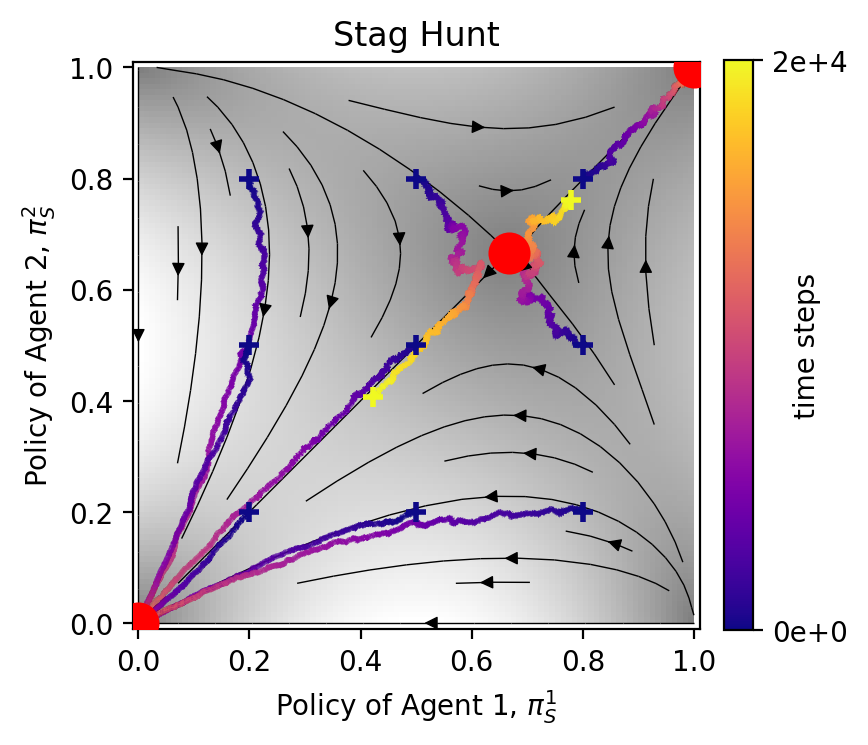

In [5]:
# Define the payoff matrix for Battle of the Sexes
A = np.array([[4, 1], [3, 3]])
B = np.array([[4, 3], [1, 3]])

# Calculate the time derivatives at each point
U, V = np.zeros(X.shape), np.zeros(Y.shape)
speed = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        x = X[i, j]
        y = Y[i, j]
        dx = f([x, y])
        U[i, j] = dx[0]
        V[i, j] = dx[1]
        speed[i, j] = np.sqrt(dx[0]**2 + dx[1]**2)

num_time_steps = int(2e4)
trajectory_array = []
for initial_probability_tupel in initial_probabilities_PD_BS:
    initial_policy_agent1 = np.array([[initial_probability_tupel[0], 1 - initial_probability_tupel[0]]])
    initial_policy_agent2 = np.array([[initial_probability_tupel[1], 1 - initial_probability_tupel[1]]])
    initial_policy_array = np.array([initial_policy_agent1, initial_policy_agent2])
    # create the agents
    agents = [CrossLearningAgent(player_id = i, 
                    action_space = action_space,
                    num_players = num_players,
                    reward_func = reward_matrix_for_two_player_stag_hunt,
                    learning_rate = learning_rate,
                    policy = initial_policy_array[i],
                    )       
                    for i in range(num_players)]
    agent1, agent2 = agents
    # Create a game and a Simulation
    game = Game(agents = agents)
    simulation = Simulation()
    # run once
    simulation.run(game, agents, num_time_steps)
    # Extract cooperation probabilities from the policy history
    p1 = [policy[0][0] for policy in agent1.policy_history]
    p2 = [policy[0][0] for policy in agent2.policy_history]
    trajectory_array.append((p1, p2))

# Set the figure size
plt.figure(figsize=figsize, dpi=dpi)
# Create the color map
if plot_imshow:
    plt.imshow(speed, extent=(0, 1, 0, 1), origin='lower', cmap=color_map, alpha=alpha)
    if not plot_CrossLearning and plot_speed_colorbar:
        plt.colorbar(label='speed')
# Plot the streamlines
plt.streamplot(X, Y, U, V, arrowsize=arrowsize, density=density, color='black', linewidth=linewidth)#, linewidth=linewidth*speed/speed.max(), color=speed, cmap=color_map)
# Plot the Nash Equilibrium 1
plt.scatter(0., 0., color='red', s=200, label='Nash Equilibrium', zorder=9, clip_on=True) # set clip_on to False to show the point outside the axes
# Plot the Nash Equilibrium 2
plt.scatter(1., 1., color='red', s=200, label='Nash Equilibrium', zorder=9, clip_on=True) # set clip_on to False to show the point outside the axes
# Plot the Nash Equilibrium 3
plt.scatter(2/3, 2/3, color='red', s=200, label='Nash Equilibrium', zorder=9, clip_on=True) # set clip_on to False to show the point outside the axes
# Plot the trajectory of Cross Learning
if plot_CrossLearning:
    # Before plotting trajectories, initialize a list to collect all lines
    all_lines = []
    for i, trajectory in enumerate(trajectory_array):
        p1, p2 = trajectory
        if plot_time_evolution:
            # Collect lines for the current trajectory
            lines = [((p1[i], p2[i]), (p1[i+1], p2[i+1])) for i in range(num_time_steps-1)]
            all_lines.extend(lines)  # Add current trajectory lines to all_lines
            start_scatter = plt.scatter(p1[0], p2[0], color=colors[0], label='start', marker='+', s=50, linewidths=2, zorder=8)
            end_scatter = plt.scatter(p1[-1], p2[-1], color=colors[-1], label='end', marker='+', s=50, linewidths=2, zorder=8)
        else:
            plt.plot(p1, p2, color=colors[i], label='Cross Learning', zorder=10)
            # plot the starting point
            start_scatter = plt.scatter(p1[0], p2[0], color=colors[i], label='start', marker='+', s=50, linewidths=2, zorder=8)

    # After collecting lines from all trajectories
    if plot_time_evolution:
        # Create a LineCollection for all trajectories
        lc = LineCollection(all_lines, cmap='plasma', linewidths=linewidth_traj)
        # Set the colors of the lines to correspond to the time steps
        lc.set_array(np.arange(num_time_steps))
        plt.gca().add_collection(lc)
        if plot_colorbar:
            # Add a colorbar for the time evolution
            cbar = plt.colorbar(lc, fraction=0.046, pad=0.04)
            cbar.set_label('time steps', labelpad=-20, y=0.5)
            tick_values = np.linspace(0, num_time_steps-1, num=num_ticks).astype(int)
            cbar.set_ticks(tick_values)  # Set the ticks to the desired positions
            # Format tick labels into scientific notation manually
            tick_labels = [0, num_time_steps]
            tick_labels_scientific_notation = ["{:.0e}".format(tick_label) for tick_label in tick_labels]
            # Define a custom formatter to remove the leading zero in the exponent
            def custom_formatter(x):
                return f'{x:.0e}'.replace('e+0', 'e+').replace('e-0', 'e-')
            tick_labels_scientific_notation_reduced = [custom_formatter(tick_label) for tick_label in tick_labels]
            cbar.set_ticklabels([tick_label for tick_label in tick_labels_scientific_notation_reduced])
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
# Make the aspect ratio of the x and y axes equal
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel(r'Policy of Agent 1, $\pi^1_S$', fontsize=fontsize)
plt.ylabel(r'Policy of Agent 2, $\pi^2_S$', fontsize=fontsize)
plt.title('Stag Hunt')
if plot_CrossLearning:
    plt.savefig(f'Figures/ReplicatorDynamics/ReplicatorDynamics_SH_CL.{file}', dpi=dpi, bbox_inches='tight', facecolor='white')
else:
    plt.savefig(f'Figures/ReplicatorDynamics/ReplicatorDynamics_SH.{file}', dpi=dpi, bbox_inches='tight', facecolor='white')
plt.show()

# Bach Stravinsky

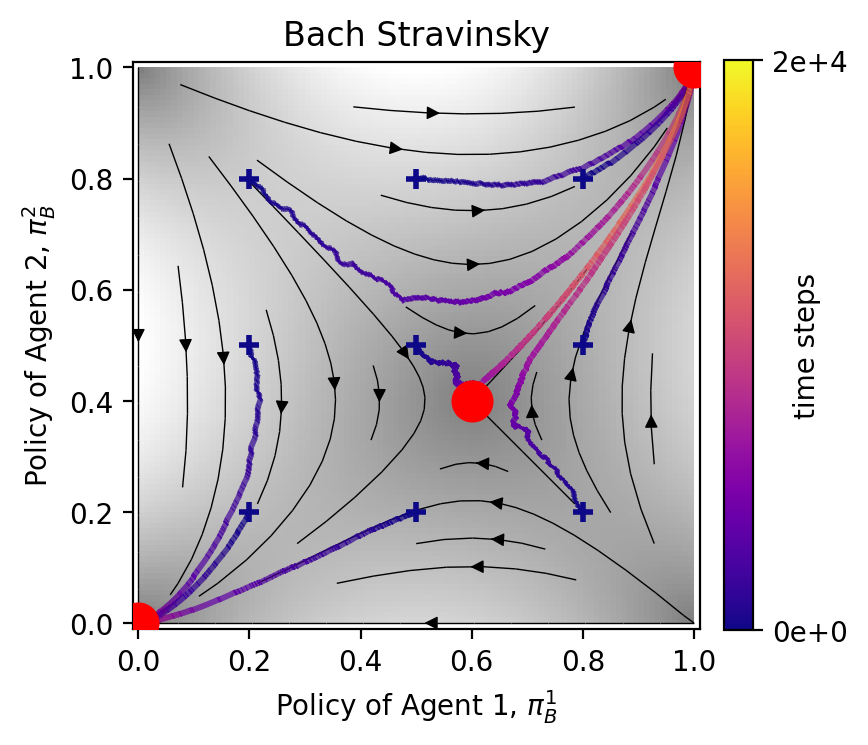

In [6]:
# Define the payoff matrix for Battle of the Sexes
A = np.array([[3, 0], [0, 2]])
B = np.array([[2, 0], [0, 3]])

# Calculate the time derivatives at each point
U, V = np.zeros(X.shape), np.zeros(Y.shape)
speed = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        x = X[i, j]
        y = Y[i, j]
        dx = f([x, y])
        U[i, j] = dx[0]
        V[i, j] = dx[1]
        speed[i, j] = np.sqrt(dx[0]**2 + dx[1]**2)

num_time_steps = int(2e4)
trajectory_array = []
for initial_probability_tupel in initial_probabilities_PD_BS:
    initial_policy_agent1 = np.array([[initial_probability_tupel[0], 1 - initial_probability_tupel[0]]])
    initial_policy_agent2 = np.array([[initial_probability_tupel[1], 1 - initial_probability_tupel[1]]])
    initial_policy_array = np.array([initial_policy_agent1, initial_policy_agent2])
    # create the agents
    agents = [CrossLearningAgent(player_id = i, 
                    action_space = action_space,
                    num_players = num_players,
                    reward_func = reward_matrix_for_two_player_battle_of_sexes,
                    learning_rate = learning_rate,
                    policy = initial_policy_array[i],
                    )       
                    for i in range(num_players)]
    agent1, agent2 = agents
    # Create a game and a Simulation
    game = Game(agents = agents)
    simulation = Simulation()
    # run once
    simulation.run(game, agents, num_time_steps)
    # Extract cooperation probabilities from the policy history
    p1 = [policy[0][0] for policy in agent1.policy_history]
    p2 = [policy[0][0] for policy in agent2.policy_history]
    trajectory_array.append((p1, p2))

# Set the figure size
plt.figure(figsize=figsize, dpi=dpi)
# Create the color map
if plot_imshow:
    plt.imshow(speed, extent=(0, 1, 0, 1), origin='lower', cmap=color_map, alpha=alpha)
    if not plot_CrossLearning and plot_speed_colorbar:
        plt.colorbar(label='speed')
# Plot the streamlines
plt.streamplot(X, Y, U, V, arrowsize=arrowsize, density=density, color='black', linewidth=linewidth)#, linewidth=linewidth*speed/speed.max(), color=speed, cmap=color_map)
# Plot the Nash Equilibrium 1
plt.scatter(0., 0., color='red', s=200, label='Nash Equilibrium', zorder=9, clip_on=True) # set clip_on to False to show the point outside the axes
# Plot the Nash Equilibrium 2
plt.scatter(1., 1., color='red', s=200, label='Nash Equilibrium', zorder=9, clip_on=True) # set clip_on to False to show the point outside the axes
# Plot the Nash Equilibrium 3
plt.scatter(3/5, 2/5, color='red', s=200, label='Nash Equilibrium', zorder=9, clip_on=True) # set clip_on to False to show the point outside the axes
# Plot the trajectory of Cross Learning
if plot_CrossLearning:
    # Before plotting trajectories, initialize a list to collect all lines
    all_lines = []
    for i, trajectory in enumerate(trajectory_array):
        p1, p2 = trajectory
        if plot_time_evolution:
            # Collect lines for the current trajectory
            lines = [((p1[i], p2[i]), (p1[i+1], p2[i+1])) for i in range(num_time_steps-1)]
            all_lines.extend(lines)  # Add current trajectory lines to all_lines
            start_scatter = plt.scatter(p1[0], p2[0], color=colors[0], label='start', marker='+', s=50, linewidths=2, zorder=8)
            end_scatter = plt.scatter(p1[-1], p2[-1], color=colors[-1], label='end', marker='+', s=50, linewidths=2, zorder=8)
        else:
            plt.plot(p1, p2, color=colors[i], label='Cross Learning', zorder=10)
            # plot the starting point
            start_scatter = plt.scatter(p1[0], p2[0], color=colors[i], label='start', marker='+', s=50, linewidths=2, zorder=8)

    # After collecting lines from all trajectories
    if plot_time_evolution:
        # Create a LineCollection for all trajectories
        lc = LineCollection(all_lines, cmap='plasma', linewidths=linewidth_traj)
        # Set the colors of the lines to correspond to the time steps
        lc.set_array(np.arange(num_time_steps))
        plt.gca().add_collection(lc)
        if plot_colorbar:
            # Add a colorbar for the time evolution
            cbar = plt.colorbar(lc, fraction=0.046, pad=0.04)
            cbar.set_label('time steps', labelpad=-20, y=0.5)
            tick_values = np.linspace(0, num_time_steps-1, num=num_ticks).astype(int)
            cbar.set_ticks(tick_values)  # Set the ticks to the desired positions
            # Format tick labels into scientific notation manually
            tick_labels = [0, num_time_steps]
            tick_labels_scientific_notation = ["{:.0e}".format(tick_label) for tick_label in tick_labels]
            # Define a custom formatter to remove the leading zero in the exponent
            def custom_formatter(x):
                return f'{x:.0e}'.replace('e+0', 'e+').replace('e-0', 'e-')
            tick_labels_scientific_notation_reduced = [custom_formatter(tick_label) for tick_label in tick_labels]
            cbar.set_ticklabels([tick_label for tick_label in tick_labels_scientific_notation_reduced])
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
# Make the aspect ratio of the x and y axes equal
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel(r'Policy of Agent 1, $\pi^1_B$', fontsize=fontsize)
plt.ylabel(r'Policy of Agent 2, $\pi^2_B$', fontsize=fontsize)
plt.title('Bach Stravinsky')
if plot_CrossLearning:
    plt.savefig(f'Figures/ReplicatorDynamics/ReplicatorDynamics_BS_CL.{file}', dpi=dpi, bbox_inches='tight', facecolor='white')
else:
    plt.savefig(f'Figures/ReplicatorDynamics/ReplicatorDynamics_BS.{file}', dpi=dpi, bbox_inches='tight', facecolor='white')
plt.show()